In [4]:
!pip install transformers

In [5]:
from transformers import AutoTokenizer
# using bert-base tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

The question and answer can be passed to the tokenizer together. The tokenizer should automatically arrange the tokens in the following format : 
# [CLS] question [SEP] context [SEP]

The start and end tokens of the correct answer from the context will be labelled by the tokenizer. See the image below for an illustration

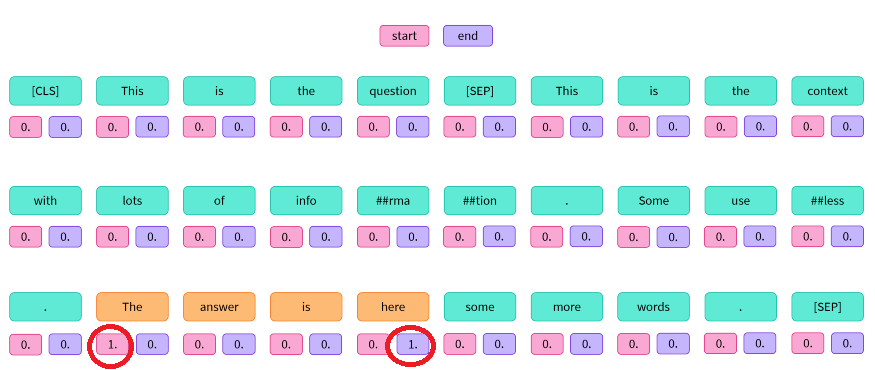

# The model should predict the start and end logit per token in the input

In [6]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [7]:
MAX_LENGTH = 112
def preprocess_training_examples(examples):
    inputs = tokenizer(
    examples["sentiment"],
    examples["text"],
    max_length = MAX_LENGTH,
    return_offsets_mapping = True,
    padding = "max_length",
    )
    start_positions = []
    end_positions = []
    for i, offset in enumerate(inputs["offset_mapping"]):
       answer = examples["selected_text"][i]
       question = examples["sentiment"][i]
       context = examples["text"][i]
    
    # finding the index of first character and the index of last        character of answer in the context(tweet_text)
    
       start_char = 0
       end_char  = 0
       for idx,ch in enumerate(context):
           count = idx
           flag = True
           for j in answer:
               if context[count] == j:
                   count +=1
               else:
                   flag = False
                   break
           if flag:
               start_char = idx
               break
       end_char = start_char + len(answer)
    # finding the start and end position of the context
       
       token_type_ids = inputs["token_type_ids"][i]
       idx = 0
       try:
           while token_type_ids[idx]!=1:
               idx+=1
           context_start = idx
           while token_type_ids[idx] ==1:
               idx+=1
               if idx == len(token_type_ids):
                   break
           context_end = idx-1
       except:
           print(token_type_ids)
    # finding the start position and end position of the token
       idx = context_start
       while idx <= context_end and offset[idx][0] <= start_char:
           idx+=1
       start_positions.append(idx-1)
    
       idx = context_end -1
       while idx >= context_start and offset[idx][1] >= end_char:
           idx-=1
       end_positions.append(idx+1)
  
       inputs["start_positions"] = start_positions
       inputs["end_positions"] = end_positions
   
       return inputs

In [8]:
from transformers import TFAutoModelForQuestionAnswering
model = TFAutoModelForQuestionAnswering.from_pretrained("bert-base-cased")

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#!pip install tensorflow-gpu

In [10]:
import pandas as pd
train_data = pd.read_csv(r"train.csv")

In [11]:
train_data.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [14]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 30.6 MB/s 
     |████████████████████████████████| 1.1 MB 42.9 MB/s 
     |████████████████████████████████| 213 kB 43.7 MB/s 
     |████████████████████████████████| 47.6 MB 121 kB/s 
     |████████████████████████████████| 352 kB 43.9 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 


In [17]:
from  official.nlp.optimization import create_optimizer

In [20]:
import tensorflow as tf
from transformers import create_optimizer

In [21]:
num_train_epochs = 10
num_train_steps = len(train_data) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)
earlyStop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=1, verbose=0,
    mode='auto',baseline=None, restore_best_weights=True)
model.fit(train_data, epochs=num_train_epochs,callbacks = [earlyStop_callback])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


ValueError: ignored